In [2]:
data=[]
file_name = "../../dataset/中国租房信息数据集.csv"
with open(file=file_name,mode='r',encoding='utf8') as f:
    f.readline()
    for idx,line in enumerate(f):
        line = line.strip()
        # 删除地址详情列
        if line:
            line = line.split(',')
            line = line[1:3]+line[-29:]
        data.append(line)
import numpy as np
data = np.array(data)
data.shape

(18886, 31)

In [3]:
# 经纬度
data[:,-6:-4]

array([['113.8226171', '22.73914878'],
       ['113.8228995', '22.66512137'],
       ['113.9455797', '22.49108674'],
       ...,
       ['114.2471828', '22.56764297'],
       ['114.2446433', '22.55905175'],
       ['114.2496825', '22.56755111']], dtype='<U18')

In [4]:
# 计算单价
def getPrice(data):
    area = np.array(data[:,8], dtype=float)
    totalPrice = np.array(data[:,4], dtype=float)
    price =  totalPrice/ area
    return price,area
price,area = getPrice(data)

In [5]:
# ! pip install folium

In [6]:
# 地图热度图
import folium
from folium.plugins import HeatMap
import pandas as pd

# 示例数据
dataFrame = pd.DataFrame({
    'latitude': data[:,-5],
    'longitude': data[:,-6],
    'value':price
})

# 创建地图
m = folium.Map(location=[31.29606705,121.5189793], zoom_start=5)

# 创建热度图
heat_data = [[row['latitude'], row['longitude'], row['value']] for index, row in dataFrame.iterrows()]
HeatMap(heat_data).add_to(m)

# 保存地图
m.save('heatmap.html')


In [7]:
# 选出离散特征预处理（去掉面积、价格和经纬度）
# 多个范围的列索引
ranges = [
    np.arange(0, 4),  
    np.arange(5, 25),  
    np.arange(28,31), 
]

# 合并多个范围的列索引
data_X = np.concatenate([data[:, idx] for idx in ranges], axis=1)
len(data_X[0])  # 27

27

In [8]:
# 存储独热编码后的列矩阵
one_hot_encoded_columns = []

# 遍历每一列
for i in range(data_X.shape[1]):
    data_column = data_X[:, i]
    unique_values, inverse_indices = np.unique(data_column, return_inverse=True)
    
    # 创建独热编码矩阵
    one_hot_matrix = np.eye(len(unique_values))[inverse_indices]
    
    one_hot_encoded_columns.append(one_hot_matrix)

# 将所有独热编码矩阵横向拼接成一个最终矩阵
result = np.hstack(one_hot_encoded_columns)

print(result)
print(result.shape)
# 输出的形状应该是 (18886, sum(每列唯一值的个数))

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(18886, 12989)


In [9]:
X = result  # 独热矩阵
# y 带单价和面积
y = np.hstack((price.reshape(-1, 1), area.reshape(-1, 1)))


In [10]:
from sklearn.decomposition import PCA # 主成分分析
pca = PCA(n_components=15) # 降维
pca.fit(X=X)
X= pca.transform(X)

In [11]:
# 数据拆分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=0)
X_train, X_test, y_train, y_test

(array([[-1.43964451,  0.39742572, -1.27541306, ...,  0.37436745,
         -0.19718966,  0.19306646],
        [-0.66648749,  1.09657513,  0.97881837, ..., -0.26225404,
         -0.80905552, -0.75002719],
        [-0.26690051,  1.41892295, -0.2753651 , ..., -0.90417531,
         -0.66440055,  0.09226001],
        ...,
        [-1.40352107,  0.34766837, -1.1785008 , ...,  0.40254521,
         -0.13486172,  0.22257503],
        [-1.34099238, -0.0557041 ,  0.65469841, ..., -0.31433905,
         -0.24728203, -0.28865686],
        [-0.43339584, -0.70540462, -0.29739515, ..., -0.13470431,
          0.69022608, -0.58844847]]),
 array([[-1.39702333,  0.42266065, -0.99818921, ...,  0.2396328 ,
          0.03625243, -0.14887713],
        [-1.01182291,  0.86505097,  0.40209599, ...,  0.39513735,
          0.02527091,  0.11502735],
        [-0.31706245, -1.89346267,  0.51205627, ..., -0.50006505,
          0.06429885,  0.47047823],
        ...,
        [-1.33645259, -0.26582322, -0.07220466, ..., -

In [12]:
# 使用 平方误差（Squared Error，SE）和 平均绝对误差（Mean Absolute Error，MAE）评估模型
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 假设有多个模型的性能指标数据
models = []
mse_scores = []   # 均方误差（MSE）分数
mae_scores = []     # 平均绝对误差（MAE）分数
r2_scores = []    # 模型解释总方差的比例，范围为0到1，越接近1说明模型越好
def assess(model,y_pred):
    # 评估模型性能
    mse = mean_squared_error(y_test[:,0]*y_test[:,1], y_pred*y_test[:,1])
    mae = mean_absolute_error(y_test[:,0]*y_test[:,1], y_pred*y_test[:,1])
    r2 = r2_score(y_test[:,0]*y_test[:,1], y_pred*y_test[:,1])
    models.append(model)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}") 
    print(f"R2 Score: {r2}")

In [13]:
# 线性回归
from sklearn.linear_model import LinearRegression

# 初始化线性回归模型
lr = LinearRegression()

# 在训练集上拟合模型
lr.fit(X_train, y_train[:,0])

# 在测试集上预测
y_pred = lr.predict(X_test)
y_pred 
assess('线性回归',y_pred)

Mean Squared Error: 160192202.96337062
Mean Absolute Error: 3441.64512699415
R2 Score: 0.4890480587625172


In [14]:
# 随机森林回归
from sklearn.ensemble import RandomForestRegressor
# 初始化随机森林回归模型
rf_regressor = RandomForestRegressor()

# 在训练集上拟合模型
rf_regressor.fit(X_train, y_train[:,0])

# 在测试集上预测
y_pred = rf_regressor.predict(X_test)

# 评估模型性能
assess('随机森林回归',y_pred)

Mean Squared Error: 95005203.97728378
Mean Absolute Error: 2606.32636551897
R2 Score: 0.6969696870268025


In [15]:
# 支持向量机
from sklearn.svm import SVR
# 初始化 SVR 模型
svr = SVR(kernel='linear', C=1.0, epsilon=0.1)  # 使用线性核函数，设置正则化参数 C 和 epsilon

# 在训练集上拟合模型
svr.fit(X_train, y_train[:,0])

# 在测试集上预测
y_pred = svr.predict(X_test)

# 评估模型性能
assess('支持向量机',y_pred)

Mean Squared Error: 171796696.65823117
Mean Absolute Error: 3463.049438081205
R2 Score: 0.45203415627050314


In [16]:
# K近邻回归
from sklearn.neighbors import KNeighborsRegressor
k = 5  # 设置K值
knn_regressor = KNeighborsRegressor(n_neighbors=k)

# 在训练集上拟合模型
knn_regressor.fit(X_train, y_train[:,0])

# 在测试集上预测
y_pred = knn_regressor.predict(X_test)

# 评估模型性能
assess('K近邻',y_pred)

Mean Squared Error: 109174042.20525865
Mean Absolute Error: 3065.288173659446
R2 Score: 0.6517765049384145


In [17]:
# 决策树回归
from sklearn.tree import DecisionTreeRegressor
# 初始化决策树回归模型
dt_regressor = DecisionTreeRegressor(random_state=42)
# 在训练集上拟合模型
dt_regressor.fit(X_train, y_train[:,0])
# 评估模型性能
assess('决策树',y_pred)

Mean Squared Error: 109174042.20525865
Mean Absolute Error: 3065.288173659446
R2 Score: 0.6517765049384145


In [18]:
# 梯度提升回归
from sklearn.ensemble import GradientBoostingRegressor
# 初始化梯度提升回归模型
gb_regressor = GradientBoostingRegressor(random_state=42)

# 在训练集上拟合模型
gb_regressor.fit(X_train, y_train[:,0])

# 在测试集上进行预测
y_pred = gb_regressor.predict(X_test)
# 评估模型性能
assess(' 梯度提升',y_pred)

Mean Squared Error: 131927988.5819059
Mean Absolute Error: 3184.5311322712087
R2 Score: 0.579200106980894


In [19]:
# 核岭回归
from sklearn.kernel_ridge import KernelRidge
# 初始化核岭回归模型
krr = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)

# 在训练集上拟合模型
krr.fit(X_train, y_train[:,0])
# 在测试集上进行预测
y_pred = krr.predict(X_test)
# 评估模型性能
assess(' 核岭回归',y_pred)

Mean Squared Error: 130283383.8665336
Mean Absolute Error: 3102.437488790286
R2 Score: 0.5844457678579089


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
# 标准化处理
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[:,0], dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test[:,0], dtype=torch.float32).view(-1, 1)

# 定义神经网络模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.layer2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

# 实例化模型
model = NeuralNetwork()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估模型
model.eval()


Epoch [10/1000], Loss: 9975.1875
Epoch [20/1000], Loss: 9886.9170
Epoch [30/1000], Loss: 9746.3770
Epoch [40/1000], Loss: 9531.2598
Epoch [50/1000], Loss: 9220.4795
Epoch [60/1000], Loss: 8792.1992
Epoch [70/1000], Loss: 8228.2529
Epoch [80/1000], Loss: 7524.3545
Epoch [90/1000], Loss: 6698.1729
Epoch [100/1000], Loss: 5796.6475
Epoch [110/1000], Loss: 4895.1733
Epoch [120/1000], Loss: 4090.2051
Epoch [130/1000], Loss: 3470.1191
Epoch [140/1000], Loss: 3072.5098
Epoch [150/1000], Loss: 2863.4595
Epoch [160/1000], Loss: 2766.8962
Epoch [170/1000], Loss: 2719.0791
Epoch [180/1000], Loss: 2690.2017
Epoch [190/1000], Loss: 2670.9319
Epoch [200/1000], Loss: 2657.4819
Epoch [210/1000], Loss: 2647.1792
Epoch [220/1000], Loss: 2638.4304
Epoch [230/1000], Loss: 2630.5586
Epoch [240/1000], Loss: 2623.3286
Epoch [250/1000], Loss: 2616.5542
Epoch [260/1000], Loss: 2610.1616
Epoch [270/1000], Loss: 2604.0823
Epoch [280/1000], Loss: 2598.2832
Epoch [290/1000], Loss: 2592.7366
Epoch [300/1000], Loss:

NeuralNetwork(
  (layer1): Linear(in_features=15, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

In [21]:
with torch.no_grad():
    y_pred = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor.numpy()*y_test[:,1], y_pred.numpy()*y_test[:,1])
    mae = mean_absolute_error(y_test_tensor.numpy()*y_test[:,1], y_pred.numpy()*y_test[:,1])
    # r2 = r2_score(y_test_tensor.numpy()[:,0]*y_test[:,1], y_pred.numpy()*y_test[:,1])
    models.append('深度学习神经网络模型')
    mse_scores.append(mse)
    mae_scores.append(mae)
    # r2_scores.append(r2)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 62066939.87
Mean Absolute Error: 2594.47


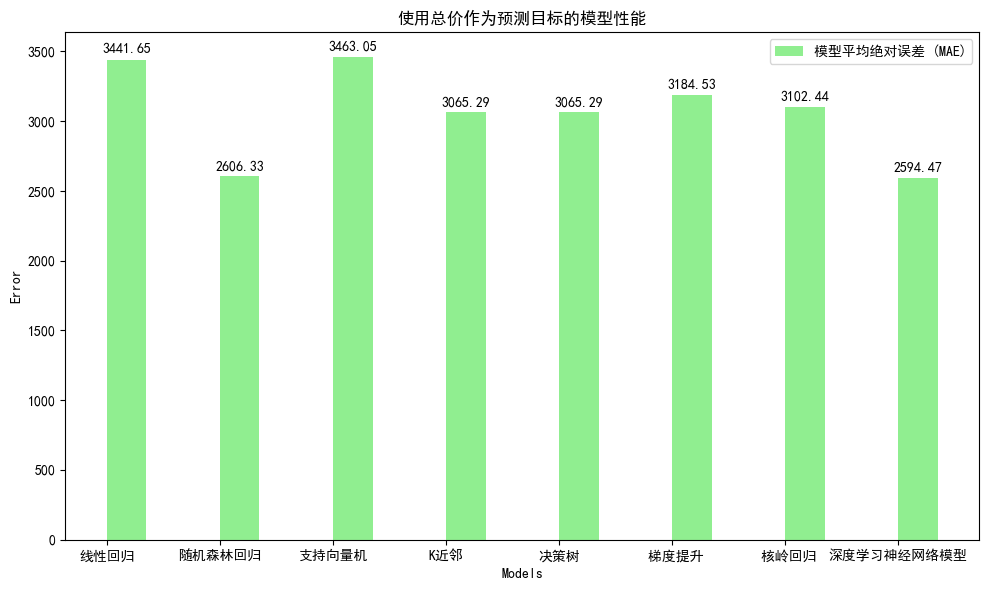

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# 设置中文字体（根据您的系统和字体库进行调整）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文显示使用的字体
# 设置条形图的宽度
bar_width = 0.35
index = np.arange(len(models))

# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))
# bar1 = ax.bar(index - bar_width/2, mse_scores, bar_width, label='Mean Squared Error (MSE)', color='skyblue')
bar2 = ax.bar(index + bar_width/2, mae_scores, bar_width, label='模型平均绝对误差 (MAE)', color='lightgreen')
# bar3 = ax.bar(index + bar_width/2, r2_scores, bar_width, label='R平方（R-squared, R²）', color='lightgreen')

# 添加标签、标题和图例
ax.set_xlabel('Models')
ax.set_ylabel('Error')
ax.set_title('使用总价作为预测目标的模型性能')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()

# 显示数值标签
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# autolabel(bar1)
autolabel(bar2)
# autolabel(bar3)

plt.tight_layout()
plt.show()


In [23]:
def actualPrediction(idx):
    y_pred = rf_regressor.predict(X[[idx],:])
    y_true = getPrice(data[[idx],:])
    y_pred*y_true[1],y_true[0]*y_true[1]
    print(f'预测值：{y_pred*y_true[1]}，实际值：{y_true[0]*y_true[1]}，误差：{y_pred*y_true[1]-y_true[0]*y_true[1]}')

In [24]:
# 使用随机森林模型预测第一条数据
actualPrediction(1)

预测值：[5406.98491436]，实际值：[4600.]，误差：[806.98491436]


In [25]:
# 使用随机森林模型预测第六条数据
actualPrediction(6)

预测值：[166817.60214976]，实际值：[220000.]，误差：[-53182.39785024]
